In [46]:
# Load and sort data

import pandas as pd
import numpy as np

df = pd.read_csv("SeoulBikeDataClean.csv", parse_dates=["datetime"])
df = df[df['functioning_day'] == 'Yes'].copy()
df = df.sort_values("datetime").reset_index(drop=True)
df['target'] = df['rented_bike_count']


In [47]:
# Add lag and rolling features

df['lag_1'] = df['target'].shift(1)
df['lag_24'] = df['target'].shift(24)
df['rolling_24_mean'] = df['target'].shift(1).rolling(24).mean()
df['rolling_168_mean'] = df['target'].shift(1).rolling(168).mean()

df = df.dropna().reset_index(drop=True)

print("New shape:", df.shape)


New shape: (8297, 41)


In [48]:
# Add holiday context features

df['date_only'] = df['datetime'].dt.date
df['is_holiday_flag'] = (df['is_holiday'] == 1).astype(int)
holiday_map = df.groupby('date_only')['is_holiday_flag'].first().to_dict()

df['is_prev_day_holiday'] = df['date_only'].apply(
    lambda d: holiday_map.get(d - pd.Timedelta(days=1), 0)
)
df['is_next_day_holiday'] = df['date_only'].apply(
    lambda d: holiday_map.get(d + pd.Timedelta(days=1), 0)
)


In [49]:
# Time-based train/val/test split

train_df = df[df['datetime'] < '2018-10-01']
val_df   = df[(df['datetime'] >= '2018-10-01') & (df['datetime'] < '2018-11-01')]
test_df  = df[df['datetime'] >= '2018-11-01']

print("Train:", train_df.shape)
print("Val:  ", val_df.shape)
print("Test: ", test_df.shape)


Train: (6984, 45)
Val:   (665, 45)
Test:  (648, 45)


In [50]:
# Feature selection and data preparation

import lightgbm as lgb

features = [
    'hour', 'temperaturec', 'humiditypct', 'wind_speed_m_s', 'visibility_10m',
    'dew_point_temperaturec', 'solar_radiation_mj_m2', 'rainfallmm', 'snowfall_cm',
    'weekday', 'month', 'is_raining', 'is_snowing', 'temperaturec_squared',
    'is_weekend', 'is_working_day',
    'lag_1', 'lag_24', 'rolling_24_mean', 'rolling_168_mean'
]

features += ['is_prev_day_holiday', 'is_next_day_holiday']

X_train = train_df[features]
y_train = train_df['target']

X_val = val_df[features]
y_val = val_df['target']

X_test = test_df[features]
y_test = test_df['target']

lgb_train = lgb.Dataset(X_train, y_train)
lgb_val   = lgb.Dataset(X_val, y_val, reference=lgb_train)

print("Feature count:", len(features))


Feature count: 22


In [51]:
# Train LightGBM model (compatible version)

from lightgbm import early_stopping, log_evaluation

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbosity': -1,
    'seed': 42
}

model = lgb.train(
    params,
    lgb_train,
    num_boost_round=500,
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train', 'val'],
    callbacks=[
        early_stopping(stopping_rounds=10),
        log_evaluation(period=20)
    ]
)

Training until validation scores don't improve for 10 rounds
[20]	train's rmse: 280.043	val's rmse: 313.481
[40]	train's rmse: 155.501	val's rmse: 209.409
[60]	train's rmse: 118.399	val's rmse: 185.485
[80]	train's rmse: 104.188	val's rmse: 174.201
[100]	train's rmse: 96.1922	val's rmse: 168.75
[120]	train's rmse: 90.7955	val's rmse: 166.554
Early stopping, best iteration is:
[125]	train's rmse: 89.2952	val's rmse: 165.539


 Test RMSE: 155.20
 Test R²:   0.8839


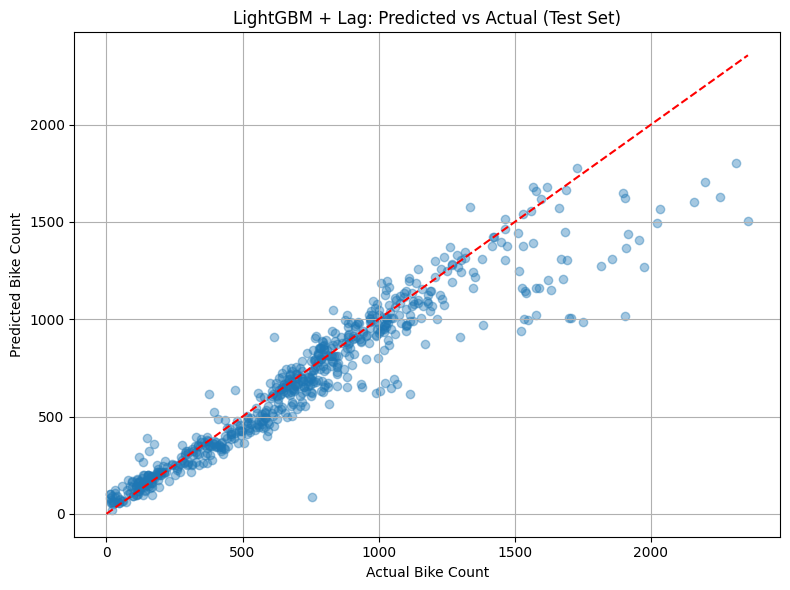

In [52]:
# Predict on test set and evaluate

from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f" Test RMSE: {rmse:.2f}")
print(f" Test R²:   {r2:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--')
plt.xlabel("Actual Bike Count")
plt.ylabel("Predicted Bike Count")
plt.title("LightGBM + Lag: Predicted vs Actual (Test Set)")
plt.grid(True)
plt.tight_layout()
plt.show()
